In [1]:
# 1. Enable Internet in the Kernel (Settings side pane)

# 2. Curl cache may need purged if v0.1.6 cannot be found (uncomment if needed). 
# !curl -X PURGE https://pypi.org/simple/kaggle-environments

# ConnectX environment was defined in v0.1.6
!pip install 'kaggle-environments==0.1.6'
!pip install ipywidgets
!pip install matplotlib
!pip install tqdm

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from kaggle_environments import evaluate, make, utils
from tqdm.notebook import tqdm
from random import choice

In [2]:
# Create env
env = make("connectx", debug=True)
env.render()

+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+



In [4]:
env.reset()
print('start')
env.render()
print('')

while not env.done:
    active = -1
    if env.state[0].status == "ACTIVE":
        active=0
    if env.state[1].status == "ACTIVE":
        active=1

    observation = env.state[active].observation
    my_action = agent_run(observation, env.configuration)
    env.step([my_action if i==active else None for i in [0,1]])

    # print and check ---
    observation = env.state[active].observation

    print('step',len(env.steps),'--------------')
    print('reward:',env.state[0].reward)
    print('info  :',env.state[0].info)
    print('mark  :',observation.mark)
    print('board :')  #6x7
    print(np.array(observation.board).reshape(env.configuration.rows, env.configuration.columns))  #6x7
    print('')

print('final!')
env.render()

start
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+
| 0 | 0 | 0 | 0 | 0 | 0 | 0 |
+---+---+---+---+---+---+---+




NameError: name 'agent_run' is not defined

In [72]:
class Agent():
    def __init__(self, conf, alpha, gamma):
        self.q_table = {}
        self.conf = conf
        self.alpha = alpha
        self.gamma = gamma
        self.eps_decay_factor = eps_decay_factor

        # Lists used to keep track of the training progression
        self.total_reward = 0
        self.all_total_rewards = []
        self.avg_rewards = []

        self.explored_states = []

    def load(self, file):
        # Load the given file as an already trained Q_table
        self.q_table = np.load(file).item()

    def __convert_board__(self, board, turn):
        # Convert board to string to add it to the Q_table
        return turn + ''.join(str(x) for x in board)

    def __push_board__(self, str_board):
        # Push the current board to the Q_table if not already present
        if not (str_board in self.q_table):
            self.q_table[str_board] = np.zeros(self.conf.columns)

    def step_train(self, obv, eps, turn):
        # Steps through the training process

        # Converts and push the current board state to the Q_table
        self.str_board = self.__convert_board__(obv.board, turn)
        self.__push_board__(self.str_board)

        # Chooses between an exploiration or exploitation move (random vs opti)
        if np.random.uniform(0, 1) < eps:
            # Selects a random action between the available moves
            action = np.random.randint(0, 7)

            while obv.board[action] != 0:
                action += 1
                action %= 7

        else:
            # Selects the most optimized action according to the Q_table
            row = self.q_table[self.str_board]
            selected_items = []

            for j in range(self.conf.columns):
                if obv.board[j] == 0:
                    selected_items.append(row[j])
                else:
                    selected_items.append(float('-inf'))

            action = int(np.argmax(selected_items))

        return action

    def train(self, action, obv, reward, status, turn):
        # Creates custom rewards and updates tracking lists if episode is done
        if status == 'DONE':
            # The agent won
            if reward == 1:
                reward = 20

            # The agent lost
            elif reward == -1:
                reward = -20

            # Draw
            else:
                reward = 5
            
            self.all_total_rewards.append(self.total_reward)
            self.total_reward = 0

            avg_reward = np.mean(self.all_total_rewards[-min(len(self.all_total_rewards), 100):])
            self.avg_rewards.append(avg_reward)

            self.explored_states.append(len(self.q_table))

        # Theoritically invalid actions are not available, but to be sure, they are punished
        elif status == 'INVALID':
            reward = -30

        # Punishing every move forces the agents to play quick games.
        else:
            reward = -0.05

        # Updates the q_table:
        #    - Push the current state if it is new
        #    - Apply Bellman equation to the q_table
        #
        # !!! ATTENTION c'est probablement cassé, à revoir

        str_board_new = self.__convert_board__(obv.board, turn)
        self.__push_board__(str_board_new)

        old_val = self.q_table[self.str_board][action]
        next_max = np.max(self.q_table[str_board_new])

        new_val = (1 - self.alpha) * old_val + self.alpha * (reward + self.gamma * next_max)
        self.q_table[self.str_board][action] = new_val

        # Updates custom lists, to keep track of the training
        self.total_reward += reward

    def __step__(self, obv, conf):
        # Steps through a turn in a real game (no random choices)
        str_board = self.__convert_board__(obv.board, '1')

        if not (str_board in self.q_table):
            # If the current states has never been faced, picks a random action
            legal_actions = [c for c in range(self.conf.columns) if obv.board[c] == 0]
            action = choice(legal_actions)

        else:
            # Else, chooses the most optimized move according to the Q_table
            row = self.q_table[str_board]
            selected_items = []

            for j in range(conf.columns):
                if obv.board[j] == 0:
                    selected_items.append(row[j])
                else:
                    selected_items.append(float('-inf'))

            action = int(np.argmax(selected_items))

        return action

    def run(self):
        # Plays a game
        return lambda obv, conf: self.__step__(obv, conf)

    def display_total_rewards(self):
        # Displays a graph of all the given rewards over the episodes played
        plt.plot(self.all_total_rewards)
        plt.xlabel('Episode')
        plt.ylabel('All rewards')
        plt.show()

    def display_avg_rewards(self):
        # Displays a graph of all the given rewards over the episodes played,
        # averaged every 100 reward to flatten the curve
        plt.plot(self.avg_rewards)
        plt.xlabel('Episode')
        plt.ylabel('Avg rewards (100)')
        plt.show()

    def display_explored_states(self):
        plt.plot(self.explored_states)
        plt.xlabel('Episode')
        plt.ylabel('Explored states')
        plt.show()

In [70]:
alpha = 0.1
gamma = 0.6
eps = 0.99
min_eps = 0.1

num_episodes = 200000

# alpha_decay_step = 1000
# alpha_decay_rate = 0.9
eps_decay_factor = 0.9999

In [71]:
# Setup diagnosis variables
all_qtable_rows = []
all_epsilons = []

# Create the two agents
agents = [Agent(env.configuration, alpha, gamma), Agent(env.configuration, alpha, gamma)]

for i in tqdm(range(num_episodes)):
    # Reset the env and get the first board status
    obv = env.reset()[0]

    # Updates the epsilon to reduce the amount of random actions
    eps *= eps_decay_factor
    eps = max(eps, min_eps)

    # Switch the playing agent
    agent_nb = i % 2 
    turn = 0

    while obv.status != 'DONE' and obv.status != 'INVALID':
        agent = agents[agent_nb]
        str_turn = str(turn + 1)
        actions = [None, None]

        # Get the action (either random to explore or from the Q_table)
        actions[turn] = agent.step_train(obv.observation, eps, str_turn)

        # Play the action
        obv = env.step(actions)[turn]

#         print('step',len(env.steps),'--------------')
#         print('player  :', str_turn)
#         print('agent  :', agent_nb)
#         print('action  :', actions[turn])
#         print('random :', random)
#         print('board :')
#         print(np.array(obv.observation.board).reshape(6, 7))
#         print('')

        # Train according to the new state of the board and the reward
        agent.train(actions[turn], obv.observation, obv.reward, obv.status, str_turn)

        turn += 1
        turn %= 2

        # Switch the agent playing
        agent_nb += 1
        agent_nb %= 2

    # Update the epsilons list to keep track of the training progression
    all_epsilons.append(eps)

  0%|          | 0/200000 [00:00<?, ?it/s]

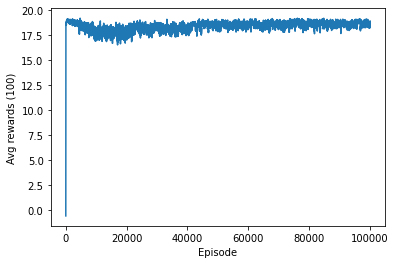

In [73]:
agents[0].display_avg_rewards()

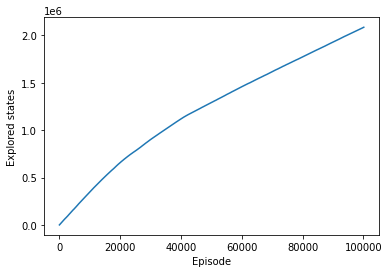

In [74]:
agents[0].display_explored_states()

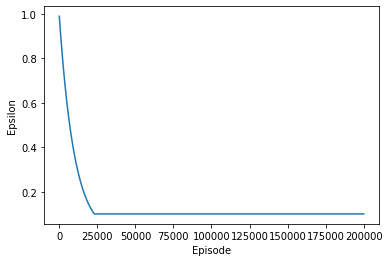

In [75]:
plt.plot(all_epsilons)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.show()

In [76]:
env.reset()

# Play as the first agent against "negamax" agent.
env.run([agents[0].run(), "negamax"])
env.render(mode="ipython", width=500, height=450)

In [29]:
# Play as first position against random agent.
trainer = env.train([None, 'negamax'])

obv = trainer.reset()

all_epochs = []
all_total_rewards = []
all_avg_rewards = []
all_qtable_rows = []
all_epsilons = []

# Loading the current table
q_table = np.load('q_table.npy',allow_pickle='TRUE').item()
# q_table = {}

for i in tqdm(range(num_episodes)):
    obv = trainer.reset()
    eps *= eps_decay_factor

    eps = max(eps, min_eps)

    epochs, total_rewards = 0, 0

    while not env.done:
        str_board = convert_board(obv.board)

        if not (str_board in q_table):
            q_table[str_board] = np.zeros(env.configuration.columns)

        if np.random.uniform(0, 1) < eps:
            legal_actions = [c for c in range(env.configuration.columns) if obv.board[c] == 0]
            action = choice(legal_actions)

        else:
            row = q_table[str_board]
            selected_items = []

            for j in range(env.configuration.columns):
                if obv.board[j] == 0:
                    selected_items.append(row[j])
                else:
                    selected_items.append(-1e7)

            action = int(np.argmax(selected_items))

        obv, reward, done, info = trainer.step(action)

        if done:
            if reward == 1:
                reward = 20
            elif reward == -1:
                reward = -20
            else:
                reward = 5
        else:
            reward = -0.05

        str_board_new = convert_board(obv.board)

        if not (str_board_new in q_table):
            q_table[str_board_new] = np.zeros(env.configuration.columns)

        old_val = q_table[str_board][action]
        next_max = np.max(q_table[str_board_new])

        new_val = old_val + alpha * (reward + gamma * next_max - old_val)
        q_table[str_board][action] = new_val

        epochs += 1
        total_rewards += reward

    all_epochs.append(epochs)

    all_total_rewards.append(total_rewards)
    avg_rewards = np.mean(all_total_rewards[max(0, i-100):(i+1)])
    all_avg_rewards.append(avg_rewards)

    all_qtable_rows.append(len(q_table))
    all_epsilons.append(eps)

  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [23]:
# Random agent function
def random_agent(observation, configuration):
    from random import choice
    return choice([c for c in range(configuration.columns) if observation.board[c] == 0])

In [37]:
def agent_run(obv, conf):
    # Test to avoid always starting be the same move
#     if np.sum(obv.board) == 0:
#         legal_actions = [c for c in range(env.configuration.columns) if obv.board[c] == 0]
#         return choice(legal_actions)

    str_board = convert_board(obv.board)

    row = q_table[str_board]
    selected_items = []

    for j in range(env.configuration.columns):
        if obv.board[j] == 0:
            selected_items.append(row[j])
        else:
            selected_items.append(-1e7)

    return int(np.argmax(selected_items))

In [39]:
env.reset()

# Play as the first agent against default "random" agent.
env.run([agent_run, "negamax"])
env.render(mode="ipython", width=500, height=450)

In [27]:
def mean_reward(rewards):
    return sum(r[0] for r in rewards) / float(len(rewards))

# Run multiple episodes to estimate its performance.
print("My Agent vs Random Agent:", mean_reward(evaluate("connectx", [agent_run, "random"], num_episodes=10)))
print("My Agent vs Negamax Agent:", mean_reward(evaluate("connectx", [agent_run, "negamax"], num_episodes=10)))

My Agent vs Random Agent: 1.0
My Agent vs Negamax Agent: 0.05


In [16]:
# "None" represents which agent you'll manually play as (first or second player).
env.play([None, agent_run], width=500, height=450)

In [28]:
# Save the q_table dictionary

np.save('q_table.npy', q_table)

In [ ]:
test = np.load('q_table.npy',allow_pickle='TRUE').item()
print(len(test))

In [ ]:
import inspect
import os

def write_agent_to_file(function, file):
    with open(file, "a" if os.path.exists(file) else "w") as f:
        f.write(inspect.getsource(function))
        print(function, "written to", file)

write_agent_to_file(agent_run, "submission.py")

In [ ]:
# Note: Stdout replacement is a temporary workaround.
import sys
out = sys.stdout
submission = utils.read_file("submission.py")
agent = utils.get_last_callable(submission)
sys.stdout = out

env = make("connectx", debug=True)
env.run([agent, agent])
print("Success!" if env.state[0].status == env.state[1].status == "DONE" else "Failed...")